#### Trisa Nguyen
#### October 17, 2022
#### ADTA 5560

### PART I: Build, Train, and Test an LSTM with Time Series Data

### Import libraries

In [1]:
# Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Time series RNN LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
# Keras:TimeseriesGenerator

# This class produces time series batches used on training/testing the model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Keras: MinMaxScaler
#This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

### Import Dataset: 

In [4]:
dir_path_dataset_1 = 'DELHI_01013_123116.csv'

### Load Dataset

In [5]:
df_ALL = pd.read_csv(dir_path_dataset_1)

In [6]:
df_ALL.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


### Exploratory Data Analysis

In [7]:
df_ALL.shape

(1462, 5)

In [8]:
df_ALL.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [9]:
# Summary statistics

df_ALL.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


#### Keep Only "Close" (for closing price) and Filter Out All Other Attributes
##### Note: The research focuses only on the closing price

In [10]:
df = df_ALL.iloc[:,1:2]

In [11]:
df.head()

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000


<AxesSubplot:>

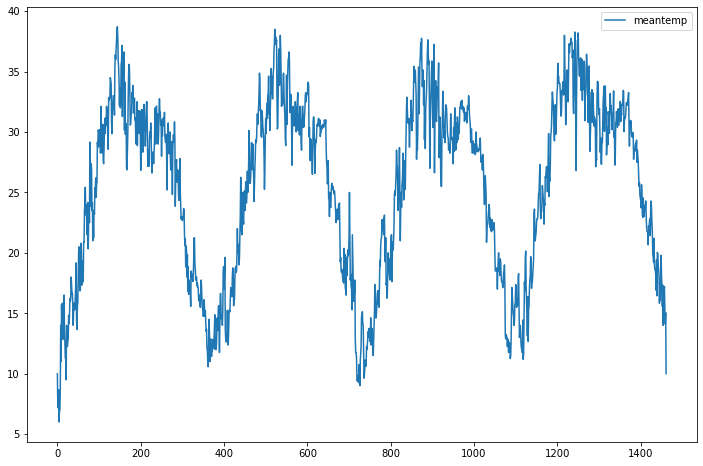

In [12]:
df.plot(figsize=(12, 8))

#### Length of Input Time Series - Number of Input Time Steps

In [13]:
# Set the length of the input sequence
# I.e the number of time series steps that are used to predict the future one
# Currently use 60 historical data points to predict the next one
# It means that 60 consecutive closing prices will be used to predict the next one.

length60 = 60

In [14]:
length60

60

### Time Series Dataset: Train/test split

In [15]:
len(df)

1462

In [16]:
# set percentage of data used for testing

test_percent = 0.1

In [17]:
# Number of data points reserved for testing the model
# 20% of the orignal dataset

len(df)*test_percent

146.20000000000002

#### Split data into Train/Test

In [18]:
# Need to find the length (number of data points) of the testing dataset
# It has been fond(above) that around 146 data points are used for testing

test_length = np.round(len(df)*test_percent)

test_length

146.0

In [19]:
# The testing data set starts at this index

# test_start_index = int(len(df)- test_length)
split_index = int(len(df) - test_length)

split_index

1316

In [20]:
# Create separate training / testing dataset

# Training dataset: All the indices from start to split_index
# Excluding split_index
data_train = df.iloc[:split_index]

# Testing dataset: All the indices from (split_index - length60) to the end of the dataframe
# Split_index - length60 needs the last 60 historical data points (belong to data_train)
# to predict the first data point of data_test
data_test = df.iloc[split_index - length60:]

In [21]:
data_train.head(5)

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000


In [22]:
data_train.tail(5)

,meantemp
1311,33.111111
1312,33.800000
1313,30.066667
1314,33.117647
1315,33.809524


In [23]:
data_test.head(5)

,meantemp
1256,36.133333
1257,33.437500
1258,35.500000
1259,36.000000
1260,32.625000


In [24]:
data_test.tail(5)

,meantemp
1457,17.217391
1458,15.238095
1459,14.095238
1460,15.052632
1461,10.000000


### Normalize Data (Scale it into the range [0,1])

In [25]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [26]:
# Ignore the warning: Just convert the data to floats
# Only scale the training data - Do not scale testing data

# Train the scaler to perform the normalization
scaler.fit(data_train)

MinMaxScaler()

In [27]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normal;ize the testing dataset
normalized_test = scaler.transform(data_test)

### Create TimeseriesGenerator for Training

In [28]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Set the length of the input sequence as above
# length60

# batch_size:Number of time series samples in each batch
# Sample: A single time series input that has 60 historical data points
batch_size32 = 32

# Create a TimeseriesGenerator for training: Train_tsGenerator
# This time series generator produces time series batches used to train the mode
# TimeseriesGenerator (input, outputs, length, batch_size)
# Normally: Inputs & outputs are the same dataset during training &testing/vaidation

train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length=length60, batch_size=batch_size32)

In [29]:
len(normalized_train)

1316

In [30]:
len(train_tsGenerator60)

40

In [31]:
# What does the first batch look like?
x,y = train_tsGenerator60[0]

In [32]:
print(x)

[[[0.12227074]
  [0.04279476]
  [0.0356623 ]
  ...
  [0.45240175]
  [0.41048035]
  [0.34643377]]

 [[0.04279476]
  [0.0356623 ]
  [0.08151383]
  ...
  [0.41048035]
  [0.34643377]
  [0.39737991]]

 [[0.0356623 ]
  [0.08151383]
  [0.        ]
  ...
  [0.34643377]
  [0.39737991]
  [0.40756914]]

 ...

 [[0.26637555]
  [0.31179039]
  [0.30567686]
  ...
  [0.50218341]
  [0.46615721]
  [0.5349345 ]]

 [[0.31179039]
  [0.30567686]
  [0.31441048]
  ...
  [0.46615721]
  [0.5349345 ]
  [0.52576419]]

 [[0.30567686]
  [0.31441048]
  [0.36681223]
  ...
  [0.5349345 ]
  [0.52576419]
  [0.59224891]]]


In [33]:
print(y)

[[0.39737991]
 [0.40756914]
 [0.35458515]
 [0.45469432]
 [0.45414847]
 [0.53275109]
 [0.55531295]
 [0.59388646]
 [0.52401747]
 [0.55021834]
 [0.5349345 ]
 [0.47379913]
 [0.4992722 ]
 [0.55531295]
 [0.43813683]
 [0.50946143]
 [0.53275109]
 [0.50436681]
 [0.70815138]
 [0.54512373]
 [0.58842795]
 [0.65338428]
 [0.6419214 ]
 [0.5349345 ]
 [0.55458515]
 [0.45851528]
 [0.50218341]
 [0.46615721]
 [0.5349345 ]
 [0.52576419]
 [0.59224891]
 [0.58588064]]


## Build, Train, and Test Model

In [34]:
# Set number of features
# Features: Attribute/variable of the data set - used as predictors

# Only using one feature: mean temperature
n_features =1

In [35]:
# Define model
model = Sequential()

# Add 1st LSTM Layer
# Activation function: relu
# MUST: return_sequences= True
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length60, n_features)))

# Add 1st Dropout Layer
model.add(Dropout(0.2))

# Add 2nd LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True))

# Add 2nd Dropout Layer
model.add(Dropout(0.2))

# Add 3rd LSTM layer
model.add(LSTM(50, activation='relu'))

# Add FC layer for final prediction
model.add(Dense(1))


### Compile Model

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

### Train(Fit) Model Using fit_generator()

In [37]:
# Train the model

model.fit_generator(train_tsGenerator60, epochs=100)

Epoch 1/100


C:\Users\trisa\AppData\Local\Temp\ipykernel_23196\4015931020.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_tsGenerator60, epochs=100)


40/40 [==============================] - 3s 29ms/step - loss: 0.1691
Epoch 2/100
40/40 [==============================] - 2s 41ms/step - loss: 0.0206
Epoch 3/100
40/40 [==============================] - 2s 41ms/step - loss: 0.0150
Epoch 4/100
40/40 [==============================] - 2s 42ms/step - loss: 0.0119
Epoch 5/100
40/40 [==============================] - 2s 42ms/step - loss: 0.0106
Epoch 6/100
40/40 [==============================] - 2s 41ms/step - loss: 0.0109
Epoch 7/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0096
Epoch 8/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0103
Epoch 9/100
40/40 [==============================] - 2s 41ms/step - loss: 0.0106
Epoch 10/100
40/40 [==============================] - 2s 42ms/step - loss: 0.0097
Epoch 11/100
40/40 [==============================] - 2s 42ms/step - loss: 0.0109
Epoch 12/100
40/40 [==============================] - 2s 41ms/step - loss: 0.0084
Epoch 13/100
40/40 [=================

### Visualize Model's Performance after training

In [38]:
loss_history_keys = model.history.history.keys()

#model.history.history is a dict
# 'loss' : its key
# 'loss':loss during training;
loss_history_keys

dict_keys(['loss'])

<AxesSubplot:>

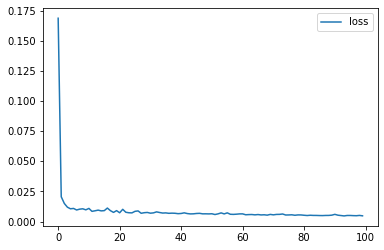

In [39]:
# Load the loss data (mode.history.history) into a dataframe
df_model_loss = pd.DataFrame(model.history.history)

#Visualize the loss data using DataFrame.plot()
df_model_loss.plot()

### Prediction for Testing: Using TimeseriesGenerator

#### Create TimeseriesGenerator for Testing

In [40]:
# batch_size must be 1
batch_size1 = 1

# Create a TimeseriesGenerator for testing: test_tsGenerator
test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length60, batch_size=batch_size1)

#### Predict Future Data Points for Test

In [41]:
normalized_prediction = model.predict_generator (test_tsGenerator60)

C:\Users\trisa\AppData\Local\Temp\ipykernel_23196\4281113417.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  normalized_prediction = model.predict_generator (test_tsGenerator60)


In [42]:
# Prediction is a numpy 2D array with only one column

normalized_prediction

array([[0.78937376],
       [0.78623354],
       [0.78393734],
       [0.765085  ],
       [0.7489944 ],
       [0.7437814 ],
       [0.7353754 ],
       [0.74219847],
       [0.74934584],
       [0.74768966],
       [0.7442913 ],
       [0.7524349 ],
       [0.7673113 ],
       [0.7712014 ],
       [0.7752402 ],
       [0.77427626],
       [0.7657998 ],
       [0.76506907],
       [0.76437396],
       [0.7670318 ],
       [0.77854705],
       [0.76821345],
       [0.75930274],
       [0.7414252 ],
       [0.7252997 ],
       [0.72688067],
       [0.7337463 ],
       [0.74483067],
       [0.75099313],
       [0.75081736],
       [0.75301147],
       [0.75940084],
       [0.7578844 ],
       [0.75879145],
       [0.75865847],
       [0.7618252 ],
       [0.7697298 ],
       [0.76760656],
       [0.76888794],
       [0.7686319 ],
       [0.7731137 ],
       [0.7770845 ],
       [0.7807204 ],
       [0.7892921 ],
       [0.7959932 ],
       [0.78253603],
       [0.77466357],
       [0.770

In [43]:
len(normalized_prediction)

146

In [44]:
# Convert normalized predictions back to the true values

prediction = scaler.inverse_transform(normalized_prediction)

In [45]:
# Flatten all the 2D array

# data_train = data_train.reshape((-1))
# data_test = data_test.reshape((-1))
# prediction = prediction.reshapre ((-1))

prediction_index = np.arange(1316, 1462, step=1)

df_prediction = pd.DataFrame(data=prediction, index=prediction_index, columns=['Prediction'])

In [46]:
df_prediction

,Prediction
1316,31.823799
1317,31.721069
1318,31.645950
1319,31.029209
1320,30.502817
...,...
1457,15.825809
1458,15.850202
1459,15.736232
1460,15.432323


### Visualize Prediction

<AxesSubplot:>

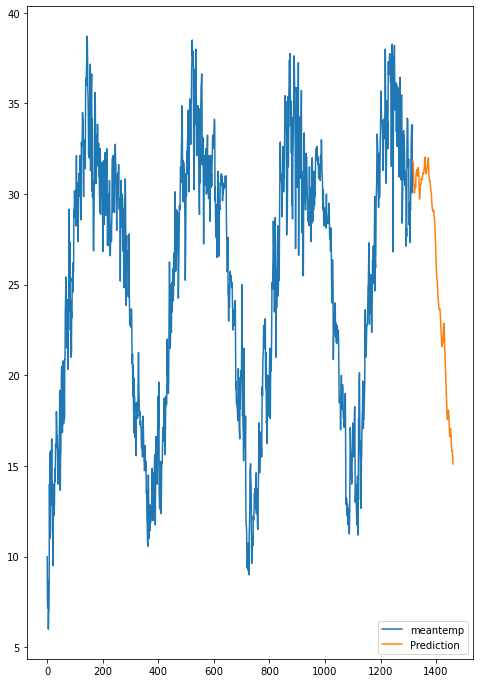

In [47]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(8,12))

### Visualize Predction and Compare Actual Mean Temperature

<AxesSubplot:>

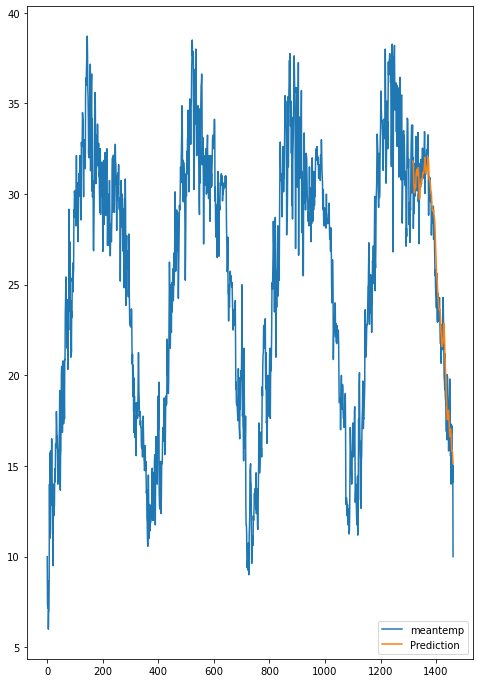

In [48]:
ax = df.plot()
df_prediction.plot( ax=ax, figsize=(8,12))

## Time Series Forecasting with LSTM

#### Overview

#### Time series forecasting:
#### - Forecasat into the "future" or unknown range
#### - Should employ all the available data
#### - i.e No splitting of the data into training/testing

#### Preprocess Full Input Dataset

In [49]:
# Still use MinMaxScaler to normalize the full input dataset df

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

#### Create TimeSeriesGenerator for Forecasting

In [50]:
# Number of time strps of the input time series
# Still use length60:
length60

60

In [51]:
# Create Timeseries Generator for forecasting

forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length=length60, batch_size=batch_size32)

#### Build, Compile, and Fit LSTM Model for Forecasting

In [52]:
# Train/Fit LSTM model
# In forecasting, we don't validate, only FORECAST
# So, no need to EarlyStop, no need for validation_generator

model.fit_generator(forecast_tsGenerator, epochs = 100)

Epoch 1/100
 3/44 [=>............................] - ETA: 1s - loss: 0.0056

C:\Users\trisa\AppData\Local\Temp\ipykernel_23196\2066943896.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(forecast_tsGenerator, epochs = 100)


44/44 [==============================] - 2s 43ms/step - loss: 0.0048
Epoch 2/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0047
Epoch 3/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0042
Epoch 4/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0045
Epoch 5/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0046
Epoch 6/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0042
Epoch 7/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0044
Epoch 8/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0044
Epoch 9/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0045
Epoch 10/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0046
Epoch 11/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0044
Epoch 12/100
44/44 [==============================] - 2s 42ms/step - loss: 0.0042
Epoch 13/100
44/44 [=================

#### Time Series Forecasting using LSTM Neural Network: 1/01/17 - 4/24/17

In [53]:
forecast = []

# Set periods with the time span of forecasting
# Let's forecast for the next 114 business days 1/01/17 - 4/24/17
periods = 114

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1, length60, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 21ms/step


#### Inverse to Transform Normalized Data Back into True Values

In [54]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[13.8469387 ],
       [13.40235275],
       [13.02604387],
       [12.70620866],
       [12.44546978],
       [12.24533013],
       [12.10215847],
       [12.00994074],
       [11.96110101],
       [11.95086001],
       [11.97391688],
       [12.02024999],
       [12.08222294],
       [12.15522271],
       [12.23467136],
       [12.31696739],
       [12.40009799],
       [12.48476415],
       [12.56807121],
       [12.64800296],
       [12.72375456],
       [12.7948707 ],
       [12.86123683],
       [12.92344621],
       [12.98167628],
       [13.03540594],
       [13.08476971],
       [13.13016977],
       [13.17139164],
       [13.20913533],
       [13.24545363],
       [13.28014667],
       [13.31148291],
       [13.33997276],
       [13.36559572],
       [13.38838643],
       [13.40843798],
       [13.42649281],
       [13.44238956],
       [13.4568653 ],
       [13.46969921],
       [13.48110334],
       [13.49124976],
       [13.5002082 ],
       [13.50803421],
       [13

In [55]:
df

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000
...,...
1457,17.217391
1458,15.238095
1459,14.095238
1460,15.052632


#### Creating new timestamp index with pandas: 1/01/17 - 2/24/17

In [56]:
# calculate forecast index

forecast_index = np.arange(1462, 1576, step=1)

In [57]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [58]:
forecast_df

,Forecast
1462,13.846939
1463,13.402353
1464,13.026044
1465,12.706209
1466,12.445470
...,...
1571,13.567436
1572,13.567439
1573,13.567440
1574,13.567443


#### Plot the forecast

<AxesSubplot:>

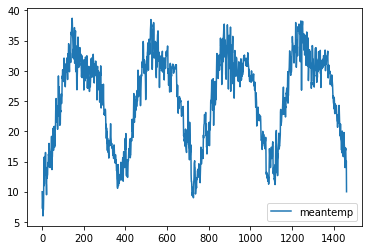

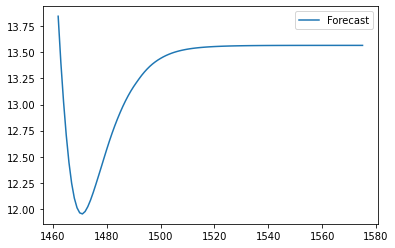

In [59]:
df.plot()
forecast_df.plot()

#### Joining Pandas Plots

<AxesSubplot:>

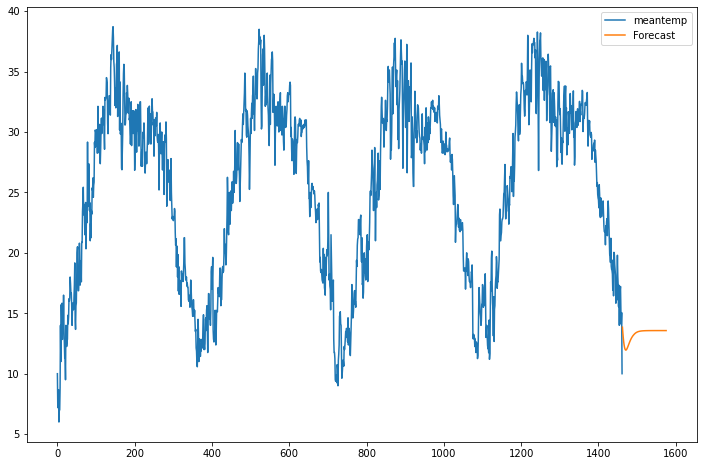

In [60]:
ax = df.plot()

forecast_df.plot(ax=ax, figsize=(12, 8))

In [61]:
dir_path_dataset_2 = 'DELHI_010117_042417.csv'

In [62]:
df_DELHI_2017 = pd.read_csv(dir_path_dataset_2)

In [63]:
df_DELHI_2017.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [64]:
df_DELHI_2017 = df_DELHI_2017.iloc[:,1:2]

In [65]:
df_DELHI_2017

,meantemp
0,15.913043
1,18.500000
2,17.111111
3,18.700000
4,18.388889
...,...
109,34.500000
110,34.250000
111,32.900000
112,32.875000


<AxesSubplot:>

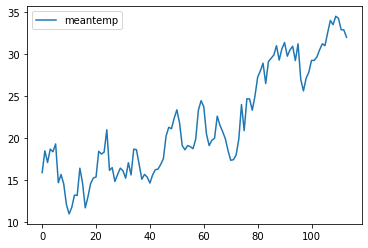

In [66]:
df_DELHI_2017.plot()

In [67]:
forecast_df['Forecast'].values

array([13.8469387 , 13.40235275, 13.02604387, 12.70620866, 12.44546978,
       12.24533013, 12.10215847, 12.00994074, 11.96110101, 11.95086001,
       11.97391688, 12.02024999, 12.08222294, 12.15522271, 12.23467136,
       12.31696739, 12.40009799, 12.48476415, 12.56807121, 12.64800296,
       12.72375456, 12.7948707 , 12.86123683, 12.92344621, 12.98167628,
       13.03540594, 13.08476971, 13.13016977, 13.17139164, 13.20913533,
       13.24545363, 13.28014667, 13.31148291, 13.33997276, 13.36559572,
       13.38838643, 13.40843798, 13.42649281, 13.44238956, 13.4568653 ,
       13.46969921, 13.48110334, 13.49124976, 13.5002082 , 13.50803421,
       13.51496083, 13.52100803, 13.52636203, 13.53110473, 13.53523906,
       13.53886494, 13.5420438 , 13.54486047, 13.5473281 , 13.54952761,
       13.55147704, 13.55321199, 13.5547456 , 13.55611055, 13.5573312 ,
       13.55841487, 13.55938691, 13.56025414, 13.56103021, 13.56172535,
       13.56234689, 13.56290262, 13.5634018 , 13.56384785, 13.56

In [68]:
df_DELHI_2017['Forecast'] = forecast_df['Forecast'].values

In [69]:
df_DELHI_2017

,meantemp,Forecast
0,15.913043,13.846939
1,18.500000,13.402353
2,17.111111,13.026044
3,18.700000,12.706209
4,18.388889,12.445470
...,...,...
109,34.500000,13.567436
110,34.250000,13.567439
111,32.900000,13.567440
112,32.875000,13.567443


<AxesSubplot:>

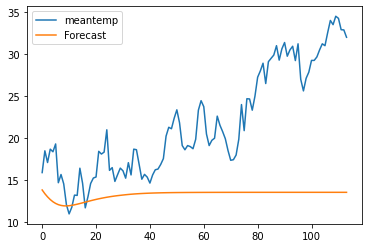

In [70]:
df_DELHI_2017.plot()